In [2]:
import numpy as np
import struct
import random
import matplotlib.pyplot as plt
import pandas as pd
import math
import cv2
import mtcnn.caffe_pb2 as pb
import math

In [3]:
class Module:
    def __init__(self, name):
        self.name = name
        self.train_mode = False

    def __call__(self, *args):
        return self.forward(*args)

    def train(self):
        self.train_mode = True
        for m in self.modules():
            m.train()

    def eval(self):
        self.train_mode = False
        for m in self.modules():
            m.eval()

    def modules(self):
        ms = []
        for attr in self.__dict__:
            m = self.__dict__[attr]
            if isinstance(m, Module):
                ms.append(m)
        return ms

    def params(self):
        ps = []
        for attr in self.__dict__:
            p = self.__dict__[attr]
            if isinstance(p, Parameter):
                ps.append(p)

        ms = self.modules()
        for m in ms:
            ps.extend(m.params())
        return ps

    def info(self, n):
        ms = self.modules()
        output = f"{self.name}\n"
        for m in ms:
            output += ('  ' * (n + 1)) + f"{m.info(n + 1)}\n"
        return output[:-1]

    def __repr__(self):
        return self.info(0)


class Initializer:
    def __init__(self, name):
        self.name = name

    def __call__(self, *args):
        return self.apply(*args)


class GaussInitializer(Initializer):
    # where :math:`\mu` is the mean and :math:`\sigma` the standard
    # deviation. The square of the standard deviation, :math:`\sigma^2`,
    # is called the variance.
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma

    def apply(self, value):
        value[...] = np.random.normal(self.mu, self.sigma, value.shape)


class Parameter:
    def __init__(self, value):
        self.value = value
        self.delta = np.zeros(value.shape)

    def zero_grad(self):
        self.delta[...] = 0


class Linear(Module):
    def __init__(self, input_feature, output_feature):
        super().__init__("Linear")
        self.input_feature = input_feature
        self.output_feature = output_feature
        self.weights = Parameter(np.zeros((input_feature, output_feature)))
        self.bias = Parameter(np.zeros((1, output_feature)))

        # 权重初始化
        initer = GaussInitializer(0, np.sqrt(2 / input_feature))  # np.sqrt(2 / input_feature)
        initer.apply(self.weights.value)

    def forward(self, x):
        self.x_save = x.copy()
        return x @ self.weights.value + self.bias.value

    #AB = C  G
    #dB = A.T @ G
    #dA = G @ B.T
    def backward(self, G):
        self.weights.delta += self.x_save.T @ G
        self.bias.delta += np.sum(G, 0)  #值复制
        return G @ self.weights.value.T


class ReLU(Module):
    def __init__(self, inplace=True):
        super().__init__("ReLU")
        self.inplace = inplace

    # 亿点点
    def forward(self, x):
        self.negative_position = x < 0
        if not self.inplace:
            x = x.copy()

        x[self.negative_position] = 0
        return x

    def backward(self, G):
        if not self.inplace:
            G = G.copy()

        G[self.negative_position] = 0
        return G


class PReLU(Module):
    def __init__(self, num_feature, inplace=False):
        super().__init__("PReLU")
        self.inplace = inplace
        self.coeff = Parameter(np.zeros((num_feature)))

    def forward(self, x):
        if not self.inplace:
            x = x.copy()

        for channel in range(x.shape[1]):
            view = x[:, channel]
            negative_position = view < 0
            view[negative_position] *= self.coeff.value[channel]
        return x


class Softmax(Module):
    def __init__(self):
        super().__init__("Softmax")

    def forward(self, x):
        expx = np.exp(x)
        sumx = np.sum(expx, axis=1, keepdims=True)
        return expx / sumx


class SWish(Module):
    def __init__(self):
        super().__init__("SWish")

    def forward(self, x):
        self.x_save = x.copy()
        self.sx = sigmoid(x)
        return x * self.sx

    def backward(self, G):
        return G * (self.sx + self.x_save * self.sx * (1 - self.sx))


class Dropout(Module):
    def __init__(self, prob_keep=0.5, inplace=True):
        super().__init__("Dropout")
        self.prob_keep = prob_keep
        self.inplace = inplace

    def forward(self, x):
        if not self.train_mode:
            return x

        self.mask = np.random.binomial(size=x.shape, p=1 - self.prob_keep, n=1)
        if not self.inplace:
            x = x.copy()

        x[self.mask] = 0
        x *= 1 / self.prob_keep  # rescale
        return x

    def backward(self, G):
        if not self.inplace:
            G = G.copy()
        G[self.mask] = 0
        G *= 1 / self.prob_keep
        return G


class Conv2d(Module):
    def __init__(self, in_feature, out_feature, kernel_size, padding=0, stride=1):
        super().__init__("Conv2d")
        self.in_feature = in_feature
        self.out_feature = out_feature
        self.kernel_size = kernel_size
        self.padding = padding
        self.stride = stride
        self.kernel = Parameter(np.ones((out_feature, in_feature, kernel_size, kernel_size)))
        self.bias = Parameter(np.zeros((out_feature)))
        initer = GaussInitializer(0, np.sqrt(2 / in_feature))  # np.sqrt(2 / input_feature)
        initer.apply(self.kernel.value)

    def forward(self, x):
        self.in_shape = x.shape
        ib, ic, ih, iw = self.in_shape
        self.oh = (ih + self.padding * 2 - self.kernel_size) // self.stride + 1
        self.ow = (iw + self.padding * 2 - self.kernel_size) // self.stride + 1
        col_w = self.oh * self.ow
        col_h = self.kernel_size * self.kernel_size * self.in_feature
        self.column = np.zeros((ib, col_h, col_w))
        self.output = np.zeros((ib, self.out_feature, self.oh, self.ow))
        khalf = self.kernel_size // 2
        self.kcol = self.kernel.value.reshape(self.out_feature, -1)
        for b in range(ib):
            for c in range(ic):
                for oy in range(self.oh):
                    for ox in range(self.ow):
                        for ky in range(self.kernel_size):
                            for kx in range(self.kernel_size):
                                column_y = ky * self.kernel_size + kx + c * self.kernel_size * self.kernel_size
                                column_x = ox + oy * self.ow
                                ix = ox * self.stride + kx - self.padding
                                iy = oy * self.stride + ky - self.padding
                                if ix >= 0 and iy >= 0 and ix < iw and iy < ih:
                                    self.column[b, column_y, column_x] = x[b, c, iy, ix]
            self.output[b] = (self.kcol @ self.column[b]).reshape(self.out_feature, self.oh,
                                                                  self.ow) + self.bias.value.reshape(self.out_feature,
                                                                                                     1, 1)
        return self.output

    #AB = C  G
    #dB = A.T @ G
    #dA = G @ B.T
    def backward(self, G):

        ib, ic, ih, iw = self.in_shape
        for b in range(ib):
            self.kernel.delta += (G[b].reshape(self.out_feature, -1) @ self.column[b].T).reshape(
                self.kernel.value.shape)

        self.bias.delta += np.sum(G, axis=(0, 2, 3))
        self.Gout = np.zeros((self.in_shape))
        for b in range(ib):
            dcolumn = self.kcol.T @ G[b].reshape(self.out_feature, -1)

            for c in range(ic):
                for oy in range(self.oh):
                    for ox in range(self.ow):
                        for ky in range(self.kernel_size):
                            for kx in range(self.kernel_size):
                                column_y = ky * self.kernel_size + kx + c * self.kernel_size * self.kernel_size
                                column_x = ox + oy * self.ow
                                ix = ox * self.stride + kx - self.padding
                                iy = oy * self.stride + ky - self.padding
                                if ix >= 0 and iy >= 0 and ix < iw and iy < ih:
                                    self.Gout[b, c, iy, ix] += dcolumn[column_y, column_x]
        return self.Gout


class Flatten(Module):
    def __init__(self):
        super().__init__("Flatten")

    def forward(self, x):
        self.in_shape = x.shape
        out = x.reshape(self.in_shape[0], -1)
        return out

    def backward(self, G):
        return G.reshape(self.in_shape)


class ModuleList(Module):
    def __init__(self, *args):
        super().__init__("ModuleList")
        self.ms = list(args)

    def modules(self):
        return self.ms

    def forward(self, x):
        for m in self.ms:
            x = m(x)
        return x

    def backward(self, G):
        for i in range(len(self.ms) - 1, -1, -1):
            G = self.ms[i].backward(G)
        return G


class MaxPooling2d(Module):
    def __init__(self, kernel_size=2, stride=2):
        super().__init__("MaxPooling2d")
        self.kernel_size = kernel_size
        self.stride = stride

    def forward(self, x):
        ib, ic, ih, iw = x.shape
        oh, ow = int(np.ceil((ih - self.kernel_size) / self.stride) + 1), int(
            np.ceil((iw - self.kernel_size) / self.stride) + 1)
        output = np.zeros((ib, ic, oh, ow))
        for b in range(ib):
            for c in range(ic):
                for oy in range(oh):
                    for ox in range(ow):
                        ix = ox * self.stride
                        iy = oy * self.stride
                        output[b, c, oy, ox] = x[b, c, iy, ix]

                        for kx in range(self.kernel_size):
                            for ky in range(self.kernel_size):
                                ix = ox * self.stride + kx
                                iy = oy * self.stride + ky
                                if ix < iw and iy < ih:
                                    output[b, c, oy, ox] = max(x[b, c, iy, ix], output[b, c, oy, ox])
        return output


class BatchNormalization(Module):
    def __init__(self, in_feature, momentum=0.9, eps=1e-8):
        self.mu = 0
        self.var = 1
        self.momentum = momentum
        self.eps = eps
        self.in_feature = in_feature
        self.gamma = Parameter(np.ones(in_feature))
        self.beta = Parameter(np.zeros(in_feature))

    def forward(self, x):
        if not self.train_mode:
            y = (x - self.mu) / np.sqrt(self.var + self.eps)
            return y * self.gamma.value.reshape(1, -1, 1, 1) + self.beta.value.reshape(1, -1, 1, 1)

        self.b_mu = np.mean(x, axis=(0, 2, 3), keepdims=True)
        self.b_var = np.var(x, axis=(0, 2, 3), keepdims=True)
        self.y = (x - self.b_mu) / np.sqrt(self.b_var + self.eps)
        self.mu = self.b_mu * self.momentum + self.mu * (1 - self.momentum)

        n = x.size / x.shape[1]
        unbiased_var = self.b_var * n / (n - 1)
        self.var = unbiased_var * self.momentum + self.var * (1 - self.momentum)
        return self.y * self.gamma.value.reshape(1, -1, 1, 1) + self.beta.value.reshape(1, -1, 1, 1)

    def backward(self, G):
        self.gamma.delta = np.sum(G * self.y, axis=(0, 2, 3))
        self.beta.delta = np.sum(G, axis=(0, 2, 3))
        return G * self.gamma.value.reshape(1, -1, 1, 1) / np.sqrt(self.b_var + self.eps)

In [4]:
def fill_conv(layer_module, layer_weight):
    kernel_param = layer_module.kernel
    bias_param = layer_module.bias
    kernel_param.value[...] = np.array(layer_weight.blobs[0].data, dtype=np.float32).reshape(kernel_param.value.shape)
    bias_param.value[...] = np.array(layer_weight.blobs[1].data, dtype=np.float32).reshape(bias_param.value.shape)


def fill_prelu(layer_module, layer_weight):
    coeff_param = layer_module.coeff
    coeff_param.value[...] = np.array(layer_weight.blobs[0].data, dtype=np.float32).reshape(coeff_param.value.shape)


class PNet(Module):  # 全卷积网络(FCN)
    def __init__(self):
        super().__init__("Model")
        self.backbone = ModuleList(
            Conv2d(3, 10, 3),
            PReLU(10),
            MaxPooling2d(),
            Conv2d(10, 16, 3),
            PReLU(16),
            Conv2d(16, 32, 3),
            PReLU(32),
        )

        self.head_confidence = Conv2d(32, 2, 1)
        self.head_bbox = Conv2d(32, 4, 1)
        self.softmax = Softmax()

    def forward(self, x):
        x = self.backbone(x)
        return self.softmax(self.head_confidence(x)), self.head_bbox(x)

    def load(self, file):
        net = pb.NetParameter()
        with open(file, "rb") as f:
            net.ParseFromString(f.read())

        layer_map = {layer.name: layer for layer in net.layer}
        bkb_names = ["conv1", "PReLU1", "pool1", "conv2", "PReLU2", "conv3", "PReLU3"]
        for layer_name, layer_module in zip(bkb_names, self.backbone.modules()):
            if isinstance(layer_module, Conv2d):
                fill_conv(layer_module, layer_map[layer_name])
            elif isinstance(layer_module, PReLU):
                fill_prelu(layer_module, layer_map[layer_name])

        fill_conv(self.head_confidence, layer_map["conv4-1"])
        fill_conv(self.head_bbox, layer_map["conv4-2"])

In [5]:
pnet = PNet()  # 实例化得到一个全卷积网络对象
pnet.load("mtcnn/det1.caffemodel")

In [6]:
# FCN  全卷积网络

In [7]:
image = cv2.imread("my.jpg").transpose(2, 0, 1)[None]
pnet(image)

(array([[[[4.99524422e-11]],
 
         [[1.00000000e+00]]]]),
 array([[[[-0.95326938]],
 
         [[ 4.97261597]],
 
         [[ 4.53516063]],
 
         [[ 8.28356677]]]]))

In [8]:
raw_image = cv2.imread("face.jpg")
input_image = cv2.resize(raw_image, (150, 150))
cv2.imwrite("150x150.jpg", input_image)

True

(1, 3, 150, 150)

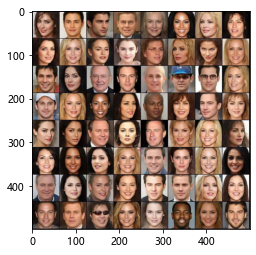

In [9]:
raw_image = cv2.imread("face.jpg")
# 转换颜色空间到RGB
# 对数据做归一化
input_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)
input_image = (input_image - 127.5) * 0.0078125
input_image = cv2.resize(input_image, (150, 150))
scale = input_image.shape[0] / raw_image.shape[0]

# h, w, c
# c, w, h
# matlab 的数据排布方式是基于列的
input_image = input_image.transpose(2, 1, 0)[None]
plt.imshow(raw_image[..., ::-1])
input_image.shape

In [10]:
pnet = PNet()  # proposal network，强调的是召回率(recall)
pnet.load("mtcnn/det1.caffemodel")

((1, 2, 70, 70), (1, 4, 70, 70))

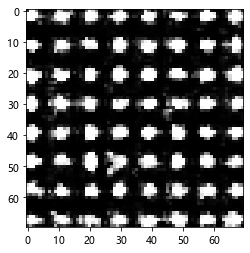

In [11]:
conf, reg = pnet(input_image)
plt.imshow(conf[0, 1], cmap="gray")
conf.shape, reg.shape

In [12]:
class BBox:
    def __init__(self, x, y, r, b, score=0):
        self.x, self.y, self.r, self.b, self.score = x, y, r, b, score

    def __xor__(self, other):
        '''
        计算box和other的IoU
        '''
        cross = self & other
        union = self | other
        return cross / (union + 1e-6)

    def __or__(self, other):
        '''
        计算box和other的并集
        '''
        cross = self & other
        union = self.area + other.area - cross
        return union

    def __and__(self, other):
        '''
        计算box和other的交集
        '''
        xmax = min(self.r, other.r)
        ymax = min(self.b, other.b)
        xmin = max(self.x, other.x)
        ymin = max(self.y, other.y)
        cross_box = BBox(xmin, ymin, xmax, ymax)
        if cross_box.width <= 0 or cross_box.height <= 0:
            return 0

        return cross_box.area

    def locations(self):
        return self.x, self.y, self.r, self.b

    @property
    def center(self):
        return (self.x + self.r) / 2, (self.y + self.b) / 2

    @property
    def area(self):
        return self.width * self.height

    @property
    def width(self):
        return self.r - self.x + 1

    @property
    def height(self):
        return self.b - self.y + 1

    def __repr__(self):
        return f"{{{self.x:.2f}, {self.y:.2f}, {self.r:.2f}, {self.b:.2f}, {self.score:.2f}}}"

In [13]:
def nms(objs, iou_threshold):
    objs = sorted(objs, key=lambda x: x.score, reverse=True)
    removed_flags = [False] * len(objs)
    keeps = []

    for i in range(len(objs)):

        if removed_flags[i]:
            continue

        base_box = objs[i]
        keeps.append(base_box)
        for j in range(i + 1, len(objs)):

            if removed_flags[j]:
                continue

            other_box = objs[j]
            iou = base_box ^ other_box

            if iou > iou_threshold:
                removed_flags[j] = True
    return keeps

935
496


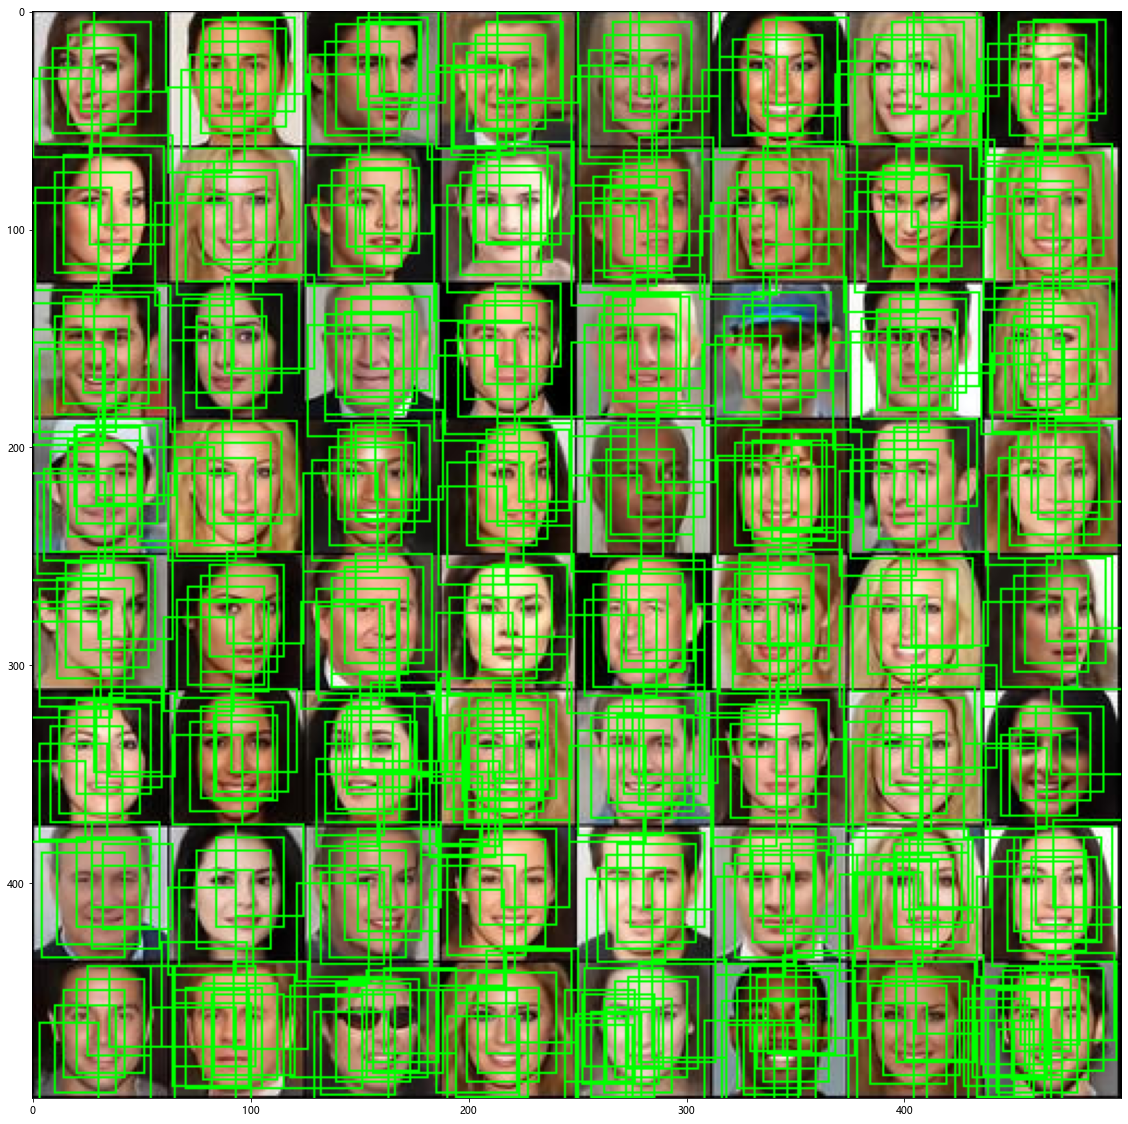

In [14]:
ys, xs = np.where(conf[0, 1] > 0.7)
stride = 2
cellsize = 12

# input_image = 150 x 150
# raw_image = 500 x 500
# scale = input_image / raw_image
show = raw_image.copy()
objs = []
for y, x in zip(ys, xs):
    score = conf[0, 1, y, x]

    # 计算的是划窗的窗口位置
    bx = (x * stride + 1) / scale
    by = (y * stride + 1) / scale
    br = (x * stride + cellsize) / scale
    bb = (y * stride + cellsize) / scale

    # reg: 1x4x70x70
    regx = reg[0, 0, y, x]
    regy = reg[0, 1, y, x]
    regr = reg[0, 2, y, x]
    regb = reg[0, 3, y, x]

    bw = br - bx + 1
    bh = bb - by + 1
    bx = bx + regx * bw
    by = by + regy * bh
    br = br + regr * bw
    bb = bb + regb * bh

    objs.append(BBox(bx, by, br, bb, score))
    #bx, by, br, bb = np.round([bx, by, br, bb]).astype(np.int32)
    #cv2.rectangle(show, (bx, by), (br, bb), (0, 255, 0), 1)

print(len(objs))
objs = nms(objs, 0.7)
print(len(objs))

for obj in objs:
    bx, by, br, bb = np.round(obj.locations()).astype(np.int32)
    cv2.rectangle(show, (bx, by), (br, bb), (0, 255, 0), 1)

# NMS(Non-Maximum Suppression)   非极大值抑制
# Soft-NMS
plt.figure(figsize=(20, 20))
plt.imshow(show[..., ::-1])

In [15]:
raw_image = cv2.imread("face.jpg")
scale = 150 / 500
input_image = cv2.resize(raw_image, (150, 150))
input_image = input_image.transpose(2, 1, 0)[None]
input_image.shape

(1, 3, 150, 150)

In [16]:
input_image = (input_image - 127.5) * 0.0078125

In [17]:
confidence, bbox = pnet(input_image)
confidence, bbox

(array([[[[9.98124162e-01, 8.72373858e-01, 7.31371802e-01, ...,
           6.96109950e-01, 9.66173459e-01, 9.89696737e-01],
          [5.75901713e-01, 9.15979110e-04, 5.92860886e-04, ...,
           6.93766944e-02, 5.06658006e-01, 9.31068489e-01],
          [5.44301111e-01, 4.69748552e-03, 8.36410527e-05, ...,
           2.91010614e-03, 2.99819488e-01, 7.93470098e-01],
          ...,
          [8.01570750e-01, 7.12581429e-02, 4.30184781e-02, ...,
           6.77787040e-03, 6.90563314e-02, 6.57785231e-01],
          [9.80311792e-01, 6.62501050e-01, 6.72439242e-01, ...,
           1.40261938e-01, 6.65283204e-01, 9.68184556e-01],
          [9.87920966e-01, 9.22110654e-01, 8.85143933e-01, ...,
           8.63340548e-01, 9.77955687e-01, 9.89320814e-01]],
 
         [[1.87583849e-03, 1.27626142e-01, 2.68628198e-01, ...,
           3.03890050e-01, 3.38265414e-02, 1.03032627e-02],
          [4.24098287e-01, 9.99084021e-01, 9.99407139e-01, ...,
           9.30623306e-01, 4.93341994e-01, 6.89315

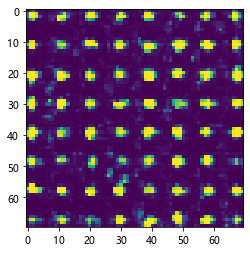

In [18]:
plt.imshow(confidence[0, 1])

In [19]:
import math


class BBox:
    def __init__(self, x, y, r, b, score=0):
        self.x, self.y, self.r, self.b, self.score = x, y, r, b, score

    def __xor__(self, other):
        '''
        计算box和other的IoU
        '''
        cross = self & other
        union = self | other
        return cross / (union + 1e-6)

    def __or__(self, other):
        '''
        计算box和other的并集
        '''
        cross = self & other
        union = self.area + other.area - cross
        return union

    def __and__(self, other):
        '''
        计算box和other的交集
        '''
        xmax = min(self.r, other.r)
        ymax = min(self.b, other.b)
        xmin = max(self.x, other.x)
        ymin = max(self.y, other.y)
        cross_box = BBox(xmin, ymin, xmax, ymax)
        if cross_box.width <= 0 or cross_box.height <= 0:
            return 0

        return cross_box.area

    def locations(self):
        return self.x, self.y, self.r, self.b

    @property
    def center(self):
        return (self.x + self.r) / 2, (self.y + self.b) / 2

    @property
    def area(self):
        return self.width * self.height

    @property
    def width(self):
        return self.r - self.x + 1

    @property
    def height(self):
        return self.b - self.y + 1

    def __repr__(self):
        return f"{{{self.x:.2f}, {self.y:.2f}, {self.r:.2f}, {self.b:.2f}, {self.score:.2f}}}"


def nms(bboxes, threshold):
    objs = sorted(bboxes, key=lambda a: a.score, reverse=True)
    flags = [False] * len(objs)
    keeps = []

    for i in range(len(objs)):
        if flags[i]:
            continue

        keeps.append(objs[i])
        for j in range(i + 1, len(objs)):
            if flags[j]:
                continue

            iou = objs[i] ^ objs[j]
            if iou > threshold:
                flags[j] = True
    return keeps

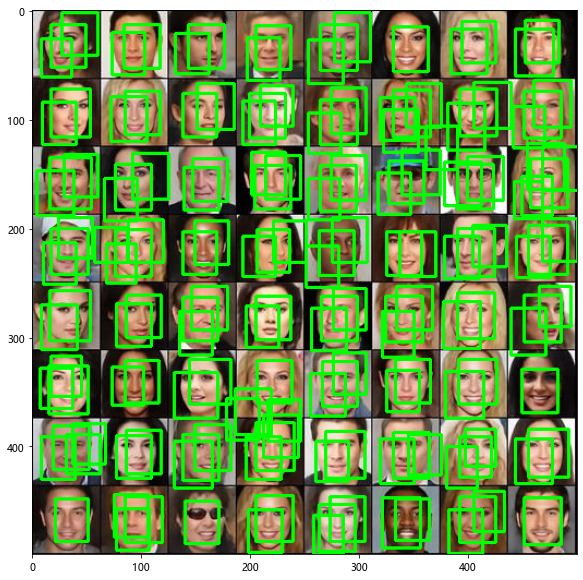

In [20]:
ys, xs = np.where(confidence[0, 1] > 0.5)

stride = 2
cellsize = 12
show = raw_image.copy()
objs = []
for y, x in zip(ys, xs):
    regx, regy, regr, regb = bbox[0, :, y, x]
    score = confidence[0, 1, y, x]
    bx = (x * stride + 1) / scale
    by = (y * stride + 1) / scale
    br = (x * stride + cellsize) / scale
    bb = (y * stride + cellsize) / scale
    bw = br - bx + 1
    bh = bb - by + 1
    bx = bx + regx * bw
    by = by + regy * bh
    br = br + regr * bw
    bb = bb + regb * bh
    objs.append(BBox(bx, by, br, bb, score))

objs = nms(objs, 0.5)
for obj in objs:
    bx, by, br, bb = np.round(obj.locations()).astype(np.int32)
    cv2.rectangle(show, (bx, by), (br, bb), (0, 255, 0), 2)

plt.figure(figsize=(10, 10))
plt.imshow(show[..., ::-1])

In [21]:
def fill_linear(layer_module, layer_weight):
    weights_param = layer_module.weights
    bias_param = layer_module.bias
    weights_param.value[...] = np.array(layer_weight.blobs[0].data, dtype=np.float32).reshape(
        *layer_weight.blobs[0].shape.dim).T
    #weights_param.value[...] = np.array(layer_weight.blobs[0].data, dtype=np.float32).reshape(weights_param.value.shape)
    bias_param.value[...] = np.array(layer_weight.blobs[1].data, dtype=np.float32).reshape(bias_param.value.shape)


class RNet(Module):
    def __init__(self):
        super().__init__("Model")
        self.backbone = ModuleList(
            Conv2d(3, 28, 3),
            PReLU(28),
            MaxPooling2d(3, 2),
            Conv2d(28, 48, 3),
            PReLU(48),
            MaxPooling2d(3, 2),
            Conv2d(48, 64, 2),
            PReLU(64),
            Flatten(),
            Linear(576, 128),
            PReLU(128)
        )

        self.head_confidence = Linear(128, 2)
        self.head_bbox = Linear(128, 4)
        self.softmax = Softmax()

    def forward(self, x):
        x = self.backbone(x)
        return self.softmax(self.head_confidence(x)), self.head_bbox(x)

    def load(self, file):
        net = pb.NetParameter()
        with open(file, "rb") as f:
            net.ParseFromString(f.read())

        layer_map = {layer.name: layer for layer in net.layer}
        bkb_names = ["conv1", "prelu1", "pool1", "conv2", "prelu2", "pool2", "conv3", "prelu3", "flatten", "conv4",
                     "prelu4"]
        for layer_name, layer_module in zip(bkb_names, self.backbone.modules()):
            if isinstance(layer_module, Conv2d):
                fill_conv(layer_module, layer_map[layer_name])
            elif isinstance(layer_module, PReLU):
                fill_prelu(layer_module, layer_map[layer_name])
            elif isinstance(layer_module, Linear):
                fill_linear(layer_module, layer_map[layer_name])

        fill_linear(self.head_confidence, layer_map["conv5-1"])
        fill_linear(self.head_bbox, layer_map["conv5-2"])

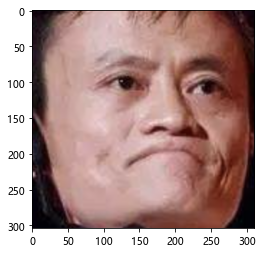

In [22]:
raw_image = cv2.imread("my2.png")
x, y, w, h = 23, 50, 311, 304
cv2.imwrite("myc.png", raw_image[y:y + h, x:x + w])
plt.imshow(raw_image[y:y + h, x:x + w, ::-1])

In [23]:
raw_image = cv2.imread("myc.png")
raw_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)
scale = 24 / raw_image.shape[0]
input_image = cv2.resize(raw_image, (24, 24)).transpose(2, 1, 0)[None]
input_image = (input_image - 127.5) * 0.0078125
input_image.shape

(1, 3, 24, 24)

In [24]:
rnet = RNet()
rnet.load("mtcnn/det2.caffemodel")

In [25]:
confidence, bbox = rnet(input_image)

In [26]:
confidence.shape, bbox.shape, confidence

((1, 2), (1, 4), array([[0.0273327, 0.9726673]]))

In [27]:
regx, regy, regr, regb = bbox[0]
score = confidence[0, 1]
cellsize = 24
imh, imw = raw_image.shape[:2]
bx = regx * imw
by = regy * imh
br = (1 + regr) * imw
bb = (1 + regb) * imh
obj = BBox(bx, by, br, bb, score)

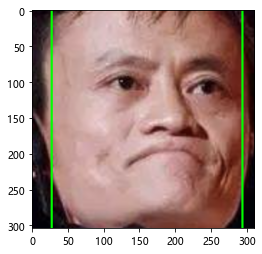

In [28]:
show = raw_image.copy()
bx, by, br, bb = np.round(obj.locations()).astype(np.int32)
cv2.rectangle(show, (bx, by), (br, bb), (0, 255, 0), 2)
plt.imshow(show)

In [29]:
class ONet(Module):
    def __init__(self):
        super().__init__("Model")
        self.backbone = ModuleList(
            Conv2d(3, 32, 3),
            PReLU(32),
            MaxPooling2d(3, 2),
            Conv2d(32, 64, 3),
            PReLU(64),
            MaxPooling2d(3, 2),
            Conv2d(64, 64, 3),
            PReLU(64),
            MaxPooling2d(2, 2),
            Conv2d(64, 128, 2),
            PReLU(128),
            Flatten(),
            Linear(1152, 256),
            PReLU(256)
        )

        self.head_confidence = Linear(256, 2)
        self.head_bbox = Linear(256, 4)
        self.head_landmark = Linear(256, 10)
        self.softmax = Softmax()

    def forward(self, x):
        x = self.backbone(x)
        return self.softmax(self.head_confidence(x)), self.head_bbox(x), self.head_landmark(x)

    def load(self, file):
        net = pb.NetParameter()
        with open(file, "rb") as f:
            net.ParseFromString(f.read())

        layer_map = {layer.name: layer for layer in net.layer}
        bkb_names = ["conv1", "prelu1", "pool1", "conv2", "prelu2", "pool2", "conv3", "prelu3", "pool3", "conv4",
                     "prelu4", "flatten", "conv5", "prelu5"]
        for layer_name, layer_module in zip(bkb_names, self.backbone.modules()):
            if isinstance(layer_module, Conv2d):
                fill_conv(layer_module, layer_map[layer_name])
            elif isinstance(layer_module, PReLU):
                fill_prelu(layer_module, layer_map[layer_name])
            elif isinstance(layer_module, Linear):
                fill_linear(layer_module, layer_map[layer_name])

        fill_linear(self.head_confidence, layer_map["conv6-1"])
        fill_linear(self.head_bbox, layer_map["conv6-2"])
        fill_linear(self.head_landmark, layer_map["conv6-3"])

In [30]:
raw_image = cv2.imread("myc.png")
raw_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)
scale = 48 / raw_image.shape[0]
input_image = cv2.resize(raw_image, (48, 48)).transpose(2, 1, 0)[None]
input_image = (input_image - 127.5) * 0.0078125
input_image.shape

(1, 3, 48, 48)

In [31]:
onet = ONet()
onet.load("mtcnn/det3.caffemodel")

In [32]:
confidence, bbox, landmark = onet(input_image)
confidence, bbox

(array([[6.22421004e-06, 9.99993776e-01]]),
 array([[ 0.08135945, -0.10554103, -0.04193136, -0.06200963]]))

In [33]:
regx, regy, regr, regb = bbox[0]
score = confidence[0, 1]
cellsize = 48
imh, imw = raw_image.shape[:2]
bx = regx * imw
by = regy * imh
br = (1 + regr) * imw
bb = (1 + regb) * imh
obj = BBox(bx, by, br, bb, score)

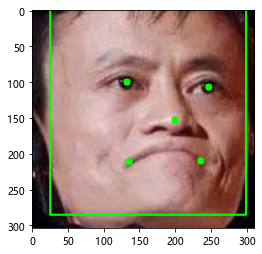

In [34]:
show = raw_image.copy()
bx, by, br, bb = np.round(obj.locations()).astype(np.int32)

for x, y in zip(landmark[0, :5], landmark[0, 5:]):
    dx = int(x * imw)
    dy = int(y * imh)
    cv2.circle(show, (dx, dy), 5, (0, 255, 0), -1)

cv2.rectangle(show, (bx, by), (br, bb), (0, 255, 0), 2)
plt.imshow(show)

In [35]:
landmark.shape

(1, 10)

# 总结
1. 这周末之前，把CNN加入BP，实现对mnist的CNN训练，实现LeNet，同时实现Dropout、BatchNorm、MaxPooling、Flatten
2. 这周完成MTCNN的完整推理过程，老师跟大家一起写，然后每个人都实现一份

In [36]:
with open("binary.bin", "rb") as f:
    image = np.frombuffer(f.read(), dtype=np.float32).reshape(48, 48, 3)

image = image.transpose(2, 0, 1)[None]

FileNotFoundError: [Errno 2] No such file or directory: 'binary.bin'

In [ ]:
image[0, :, :4, :4]

In [ ]:
onet.backbone.ms[0].kernel.value.shape

In [ ]:
confidence, bbox, landmark = onet(image)
confidence, bbox